# MIMIC-CXR Exploratory Data Analysis

This notebook performs exploratory data analysis on the available MIMIC-CXR studies.
We'll analyze:
- Dataset size and composition
- Label distributions (CheXpert and NegBio)
- Train/validation/test split balance
- Image availability patterns
- Study characteristics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [3]:
# Load the data
data_path = Path('../data/raw/available_studies_complete.csv')
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (226844, 11)

Columns: ['study_id', 'subject_id', 'found_images', 'expected_images', 'is_complete', 'completeness_ratio', 'split', 'has_chexpert_labels', 'has_negbio_labels', 'image_paths', 'dicom_ids']

First few rows:


,study_id,subject_id,found_images,expected_images,is_complete,completeness_ratio,split,has_chexpert_labels,has_negbio_labels,image_paths,dicom_ids
0,s50414267,p10000032,2,2,True,1.0,train,True,True,E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg...,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014|1...
1,s53189527,p10000032,2,2,True,1.0,train,True,True,E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg...,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab|e...
2,s53911762,p10000032,2,2,True,1.0,train,True,True,E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg...,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714|f...
3,s56699142,p10000032,1,1,True,1.0,train,True,True,E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg...,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c
4,s57375967,p10000764,3,3,True,1.0,train,True,True,E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg...,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4|b...


In [4]:
# Basic dataset statistics
print("=== DATASET OVERVIEW ===")
print(f"Total studies: {len(df)}")
print(f"Total subjects: {df['subject_id'].nunique()}")
print(f"Average studies per subject: {len(df) / df['subject_id'].nunique():.2f}")
print(f"\nImages per study:")
print(df['found_images'].value_counts().sort_index())

=== DATASET OVERVIEW ===
Total studies: 226844
Total subjects: 65202
Average studies per subject: 3.48

Images per study:
found_images
1     102419
2     102931
3      19282
4       2072
5         99
6         33
7          2
8          4
9          1
11         1
Name: count, dtype: int64


## Dataset Split Distribution

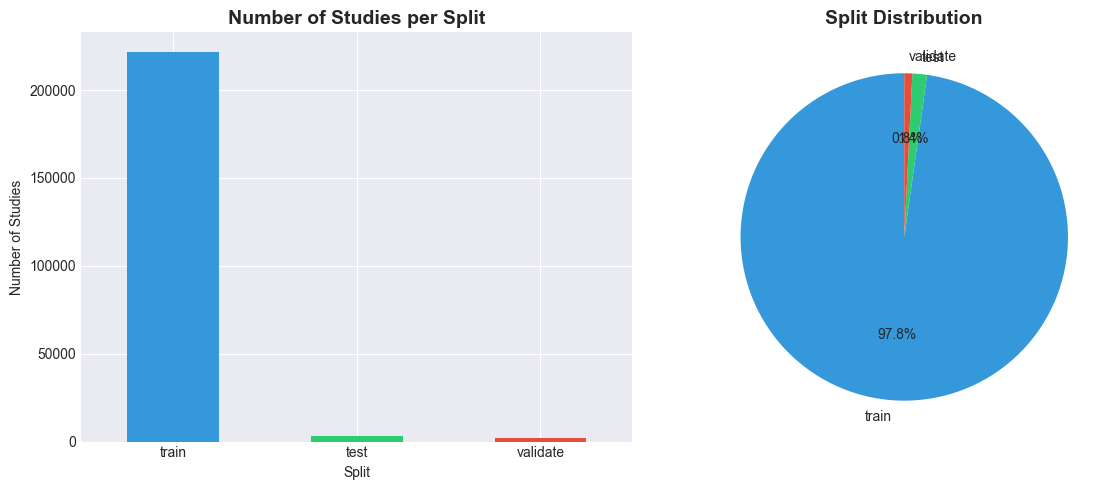

Split Statistics:
  train: 221789 studies (97.77%)
  validate: 1797 studies (0.79%)
  test: 3258 studies (1.44%)


In [5]:
# Analyze train/val/test splits
split_counts = df['split'].value_counts()
split_percentages = (split_counts / len(df) * 100).round(2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar plot
split_counts.plot(kind='bar', ax=ax1, color=['#3498db', '#2ecc71', '#e74c3c'])
ax1.set_title('Number of Studies per Split', fontsize=14, fontweight='bold')
ax1.set_xlabel('Split')
ax1.set_ylabel('Number of Studies')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
colors = ['#3498db', '#2ecc71', '#e74c3c']
wedges, texts, autotexts = ax2.pie(split_counts, labels=split_counts.index, autopct='%1.1f%%', 
                                    colors=colors, startangle=90)
ax2.set_title('Split Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Split Statistics:")
for split in ['train', 'validate', 'test']:
    count = split_counts.get(split, 0)
    pct = split_percentages.get(split, 0)
    print(f"  {split}: {count} studies ({pct}%)")

## Label Availability

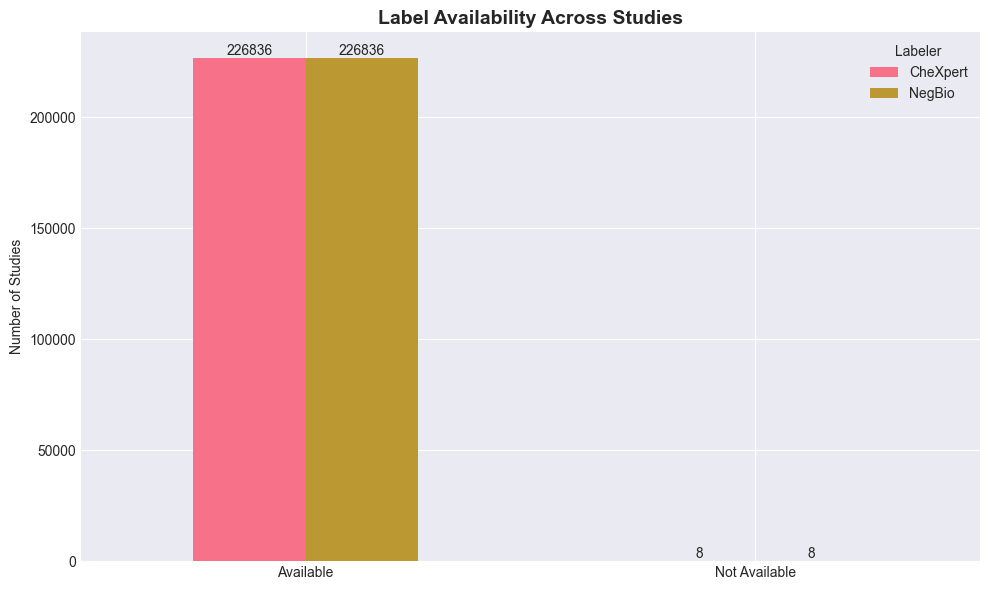

Studies with CheXpert labels: 226836 (100.0%)
Studies with NegBio labels: 226836 (100.0%)
Studies with both labels: 226836


In [6]:
# Check label availability
label_availability = pd.DataFrame({
    'CheXpert': [df['has_chexpert_labels'].sum(), (~df['has_chexpert_labels']).sum()],
    'NegBio': [df['has_negbio_labels'].sum(), (~df['has_negbio_labels']).sum()]
}, index=['Available', 'Not Available'])

fig, ax = plt.subplots(figsize=(10, 6))
label_availability.plot(kind='bar', ax=ax, rot=0)
ax.set_title('Label Availability Across Studies', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Studies')
ax.legend(title='Labeler')

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

print(f"Studies with CheXpert labels: {df['has_chexpert_labels'].sum()} ({df['has_chexpert_labels'].sum()/len(df)*100:.1f}%)")
print(f"Studies with NegBio labels: {df['has_negbio_labels'].sum()} ({df['has_negbio_labels'].sum()/len(df)*100:.1f}%)")
print(f"Studies with both labels: {(df['has_chexpert_labels'] & df['has_negbio_labels']).sum()}")

## Label Distribution Analysis

To analyze the actual label distributions, we need to load the label files. 
This section will only run if you have the label CSV files available.

Loading CheXpert labels...
Loaded 226836 CheXpert labels for available studies


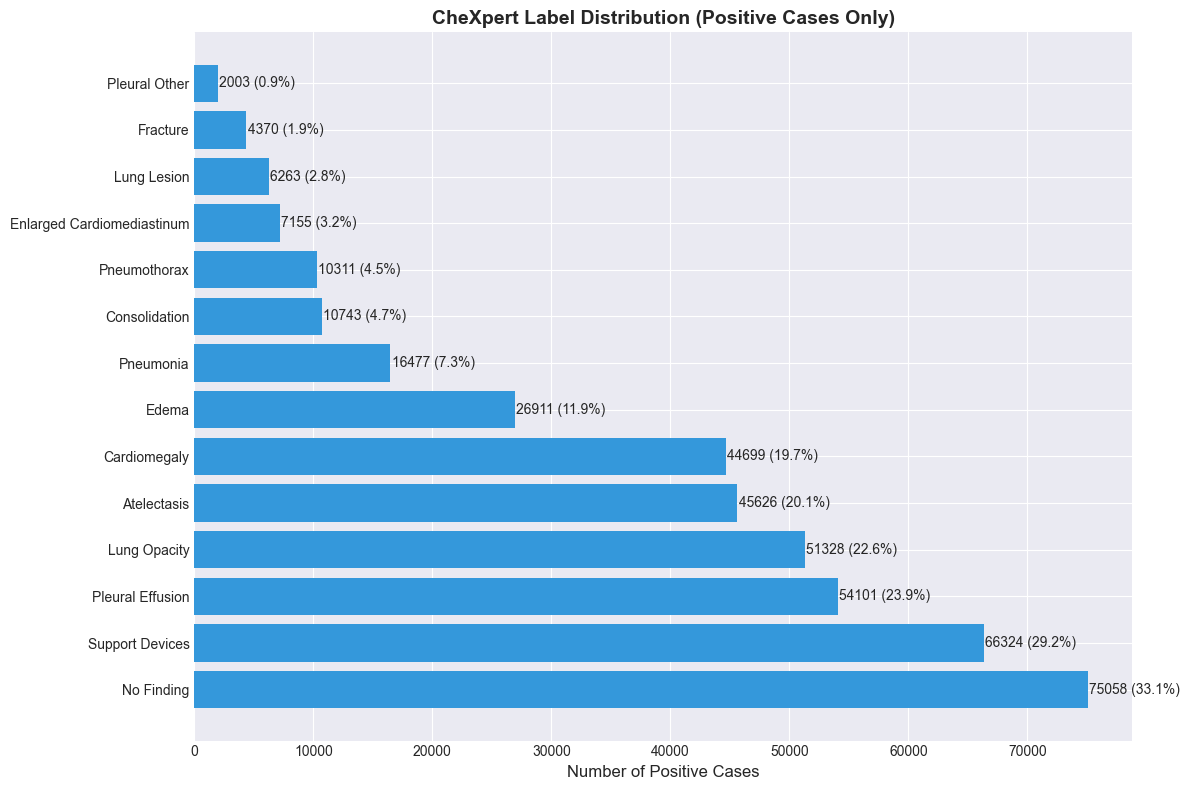


=== Label Uncertainty Analysis ===

Top 5 conditions with most uncertainty:
                            Positive  Uncertain  Negative
Pneumonia                      16477      18219     24209
Edema                          26911      13121     25537
Atelectasis                    45626      10294      1524
Enlarged Cardiomediastinum      7155       9343      5259
Cardiomegaly                   44699       6025     15822


In [7]:
# Try to load label files if available
try:
    # Adjust these paths based on where your label files are located
    chexpert_path = Path('../../../MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-chexpert.csv.gz')
    negbio_path = Path('../../../MIMIC-CXR/physionet.org/files/mimic-cxr-jpg/2.1.0/mimic-cxr-2.0.0-negbio.csv.gz')
    
    if chexpert_path.exists():
        print("Loading CheXpert labels...")
        chexpert_df = pd.read_csv(chexpert_path, compression='gzip')
        
        # Get studies that are in our available set
        available_study_ids = df['study_id'].str[1:].astype(int)  # Remove 's' prefix
        chexpert_subset = chexpert_df[chexpert_df['study_id'].isin(available_study_ids)]
        
        print(f"Loaded {len(chexpert_subset)} CheXpert labels for available studies")
        
        # Label columns
        label_columns = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 
                        'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 
                        'Lung Opacity', 'Pleural Effusion', 'Pneumonia', 
                        'Pneumothorax', 'Pleural Other', 'Support Devices', 'No Finding']
        
        # Calculate positive label frequencies
        positive_counts = {}
        for col in label_columns:
            if col in chexpert_subset.columns:
                positive_counts[col] = (chexpert_subset[col] == 1.0).sum()
        
        # Sort by frequency
        positive_counts = dict(sorted(positive_counts.items(), key=lambda x: x[1], reverse=True))
        
        # Plot label distribution
        fig, ax = plt.subplots(figsize=(12, 8))
        labels = list(positive_counts.keys())
        values = list(positive_counts.values())
        
        bars = ax.barh(labels, values, color='#3498db')
        ax.set_xlabel('Number of Positive Cases', fontsize=12)
        ax.set_title('CheXpert Label Distribution (Positive Cases Only)', fontsize=14, fontweight='bold')
        
        # Add value labels
        for i, (label, value) in enumerate(zip(labels, values)):
            percentage = value / len(chexpert_subset) * 100
            ax.text(value + 100, i, f'{value} ({percentage:.1f}%)', 
                   va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Uncertainty analysis
        print("\n=== Label Uncertainty Analysis ===")
        uncertain_counts = {}
        for col in label_columns:
            if col in chexpert_subset.columns:
                uncertain_counts[col] = (chexpert_subset[col] == -1.0).sum()
        
        uncertain_df = pd.DataFrame({
            'Positive': positive_counts,
            'Uncertain': uncertain_counts,
            'Negative': {col: (chexpert_subset[col] == 0.0).sum() for col in label_columns if col in chexpert_subset.columns}
        }).fillna(0)
        
        # Show top conditions with uncertainty
        print("\nTop 5 conditions with most uncertainty:")
        uncertain_sorted = uncertain_df.sort_values('Uncertain', ascending=False)
        print(uncertain_sorted[['Positive', 'Uncertain', 'Negative']].head())
        
    else:
        print("CheXpert label file not found. Skipping label distribution analysis.")
        print(f"Expected path: {chexpert_path}")
        
except Exception as e:
    print(f"Could not load label files: {e}")
    print("Continuing with available data analysis...")

## Studies per Patient Analysis

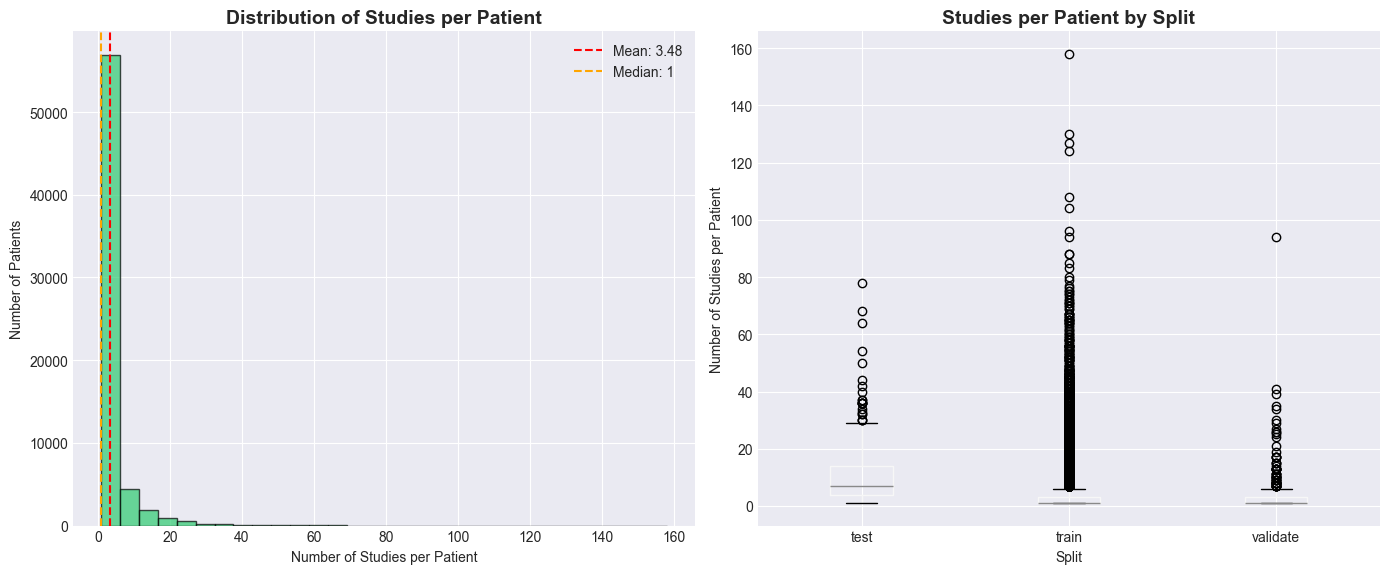

Studies per Patient Statistics:
  Mean: 3.48
  Median: 1
  Min: 1
  Max: 158
  Patients with >10 studies: 4457


In [8]:
# Analyze studies per patient
studies_per_patient = df.groupby('subject_id').size()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram
ax1.hist(studies_per_patient, bins=30, edgecolor='black', alpha=0.7, color='#2ecc71')
ax1.set_xlabel('Number of Studies per Patient')
ax1.set_ylabel('Number of Patients')
ax1.set_title('Distribution of Studies per Patient', fontsize=14, fontweight='bold')
ax1.axvline(studies_per_patient.mean(), color='red', linestyle='--', 
            label=f'Mean: {studies_per_patient.mean():.2f}')
ax1.axvline(studies_per_patient.median(), color='orange', linestyle='--', 
            label=f'Median: {studies_per_patient.median():.0f}')
ax1.legend()

# Box plot by split
patient_split = df.groupby('subject_id')['split'].first()
studies_by_split = pd.DataFrame({
    'studies_count': studies_per_patient,
    'split': patient_split
})

studies_by_split.boxplot(column='studies_count', by='split', ax=ax2)
ax2.set_xlabel('Split')
ax2.set_ylabel('Number of Studies per Patient')
ax2.set_title('Studies per Patient by Split', fontsize=14, fontweight='bold')
plt.suptitle('')  # Remove automatic title

plt.tight_layout()
plt.show()

print("Studies per Patient Statistics:")
print(f"  Mean: {studies_per_patient.mean():.2f}")
print(f"  Median: {studies_per_patient.median():.0f}")
print(f"  Min: {studies_per_patient.min()}")
print(f"  Max: {studies_per_patient.max()}")
print(f"  Patients with >10 studies: {(studies_per_patient > 10).sum()}")

## Images per Study Analysis

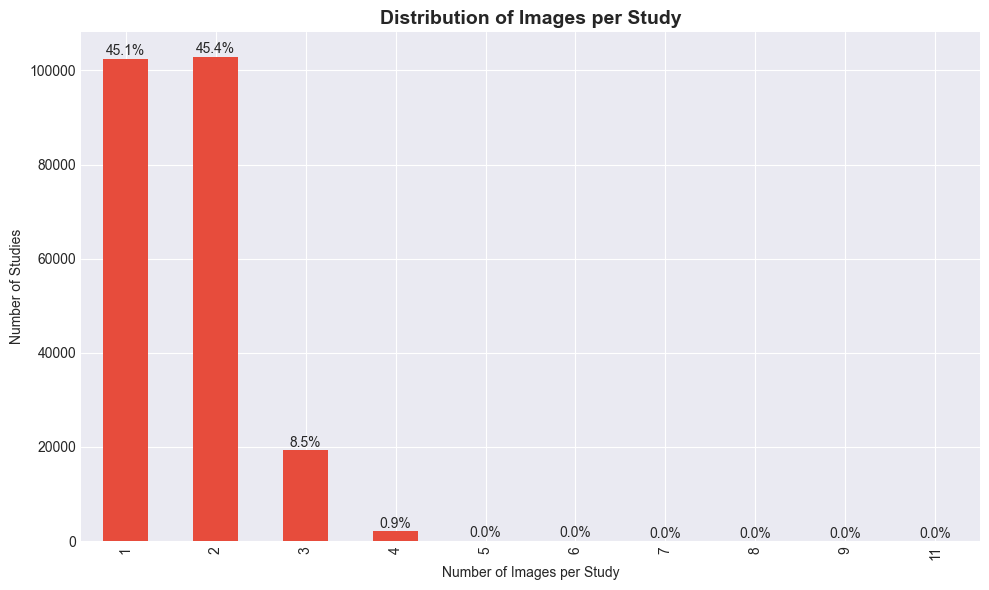

Images per Study:
  1 image(s): 102419 studies (45.1%)
  2 image(s): 102931 studies (45.4%)
  3 image(s): 19282 studies (8.5%)
  4 image(s): 2072 studies (0.9%)
  5 image(s): 99 studies (0.0%)
  6 image(s): 33 studies (0.0%)
  7 image(s): 2 studies (0.0%)
  8 image(s): 4 studies (0.0%)
  9 image(s): 1 studies (0.0%)
  11 image(s): 1 studies (0.0%)


In [9]:
# Analyze images per study
images_dist = df['found_images'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(10, 6))
images_dist.plot(kind='bar', ax=ax, color='#e74c3c')
ax.set_xlabel('Number of Images per Study')
ax.set_ylabel('Number of Studies')
ax.set_title('Distribution of Images per Study', fontsize=14, fontweight='bold')

# Add percentage labels
total_studies = len(df)
for i, (num_images, count) in enumerate(images_dist.items()):
    percentage = count / total_studies * 100
    ax.text(i, count + 100, f'{percentage:.1f}%', 
           ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("Images per Study:")
for num_images, count in images_dist.items():
    percentage = count / total_studies * 100
    print(f"  {num_images} image(s): {count} studies ({percentage:.1f}%)")

## Sample Image Paths

Let's examine the structure of image paths to understand the data organization.

In [10]:
# Sample some image paths
sample_studies = df.sample(5, random_state=42)
print("Sample Image Paths:")
for idx, row in sample_studies.iterrows():
    print(f"\nStudy: {row['study_id']} (Subject: {row['subject_id']})")
    print(f"Split: {row['split']}")
    print(f"Number of images: {row['found_images']}")
    
    # Parse image paths
    if pd.notna(row['image_paths']):
        paths = row['image_paths'].split('|')
        for path in paths[:2]:  # Show first 2 paths
            print(f"  - {path}")
        if len(paths) > 2:
            print(f"  ... and {len(paths) - 2} more")

Sample Image Paths:

Study: s58507744 (Subject: p15472839)
Split: train
Number of images: 2
  - E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg\2.1.0\files\p15\p15472839\s58507744\663808e1-f7525f4c-9fb093ad-4316b481-ad9f77a2.jpg
  - E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg\2.1.0\files\p15\p15472839\s58507744\966b03e1-b2a01275-567d58ca-34b2eeda-f0e01382.jpg

Study: s52279057 (Subject: p12316130)
Split: train
Number of images: 2
  - E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg\2.1.0\files\p12\p12316130\s52279057\bd2b97fa-1cfe3b80-7e79da6e-53bcee0c-a0f90662.jpg
  - E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg\2.1.0\files\p12\p12316130\s52279057\c87260e9-f8d07dcd-7c526f3b-b8ef1b1e-17ebd007.jpg

Study: s59030565 (Subject: p14184360)
Split: train
Number of images: 2
  - E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg\2.1.0\files\p14\p14184360\s59030565\0a29ec13-26b2202f-351e21ee-2826c6bd-5bceba77.jpg
  - E:\MIMIC-CXR\physionet.org\files\mimic-cxr-jpg\2.1.0\files\p14\p14184360\s590305

## Summary Statistics

In [11]:
# Create a comprehensive summary
print("=== MIMIC-CXR DATASET SUMMARY ===")
print(f"\nDataset Size:")
print(f"  Total studies: {len(df):,}")
print(f"  Total subjects: {df['subject_id'].nunique():,}")
print(f"  Total images: {df['found_images'].sum():,}")

print(f"\nSplit Distribution:")
for split, count in df['split'].value_counts().items():
    print(f"  {split}: {count:,} ({count/len(df)*100:.1f}%)")

print(f"\nLabel Coverage:")
print(f"  CheXpert: {df['has_chexpert_labels'].sum():,} ({df['has_chexpert_labels'].sum()/len(df)*100:.1f}%)")
print(f"  NegBio: {df['has_negbio_labels'].sum():,} ({df['has_negbio_labels'].sum()/len(df)*100:.1f}%)")

print(f"\nCompleteness:")
print(f"  All studies are complete (100% of expected images)")
print(f"  Average completeness ratio: {df['completeness_ratio'].mean():.3f}")

# Save summary statistics
summary_stats = {
    'total_studies': len(df),
    'total_subjects': df['subject_id'].nunique(),
    'total_images': df['found_images'].sum(),
    'studies_per_subject_mean': studies_per_patient.mean(),
    'studies_per_subject_median': studies_per_patient.median(),
    'chexpert_coverage': df['has_chexpert_labels'].sum() / len(df),
    'negbio_coverage': df['has_negbio_labels'].sum() / len(df)
}

# You can save this for later reference
# import json
# with open('../data/dataset_summary.json', 'w') as f:
#     json.dump(summary_stats, f, indent=2)

print("\n✓ Exploratory analysis complete!")

=== MIMIC-CXR DATASET SUMMARY ===

Dataset Size:
  Total studies: 226,844
  Total subjects: 65,202
  Total images: 375,174

Split Distribution:
  train: 221,789 (97.8%)
  test: 3,258 (1.4%)
  validate: 1,797 (0.8%)

Label Coverage:
  CheXpert: 226,836 (100.0%)
  NegBio: 226,836 (100.0%)

Completeness:
  All studies are complete (100% of expected images)
  Average completeness ratio: 1.000

✓ Exploratory analysis complete!
